# Visualizar progreso de casos activos de COVID-19 en Chile

## Introducción

*El objetivo de este Notebook es utilizar la herramienta de la librería Folium para crear un mapa coroplético con una barra deslizante de tiempo y así poder observar de forma interactiva el progreso de los casos activos de COVID-19 en Chile actualizando la información conforme se va agregando al repositorio fuente.*

**Si el concepto de mapa coroplético con barra deslizante de tiempo no queda del todo claro (y no culparía a nadie por ello) podemos ver un ejemplo gráfico a continuación:**

<div style="margin:1px auto, position: absolute">
<img src="image/200823 Chile.gif" width="800" height="300" align="center"/>
</div>

**Es este en efecto el mapa que generaremos en el transcurso de este Notebook**

Habiendo dicho esto y para llegar a ello, vamos a comenzar explorando la data que el Ministerio de Ciencia ha puesto a disposición en su repositorio de **GitHub**. Dicho repositorio está disponible aquí:

https://github.com/MinCiencia/Datos-COVID19

Será necesario importar algunas librerías, pero antes una **nota importante** :

**Como vamos a utilizar geopandas es altamente recomendable crear un entorno especial para esta herramienta.**

In [1]:
from IPython.display import IFrame

import numpy as np
import pandas as pd
import geopandas as gp

import matplotlib
import matplotlib.pyplot as plt

import folium
from folium.plugins import TimeSliderChoropleth

from datetime import datetime
from colour import Color

# Exploración y tratamiento de datos

**Vamos a importar el Producto 19 que se define como:**

" Archivo que da cuenta del número de casos confirmados activos notificados en cada una de las comunas de Chile, según residencia, y concatena la historia de los informes epidemiológicos publicados por el Ministerio de Salud del país. [...]"

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto19/CasosActivosPorComuna.csv",header=0)
df.head()

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,2020-04-13,2020-04-15,2020-04-17,2020-04-20,2020-04-24,...,2020-06-15,2020-06-19,2020-06-23,2020-06-28,2020-07-01,2020-07-05,2020-07-10,2020-07-13,2020-07-17,2020-07-20
0,Arica y Parinacota,15,Arica,15101.0,247552.0,88.0,80.0,72.0,65.0,77.0,...,353.0,358.0,381.0,408.0,406.0,495.0,575.0,655.0,818.0,859.0
1,Arica y Parinacota,15,Camarones,15102.0,1233.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0,12.0
2,Arica y Parinacota,15,General Lagos,15202.0,810.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arica y Parinacota,15,Putre,15201.0,2515.0,0.0,0.0,0.0,0.0,0.0,...,3.0,8.0,7.0,1.0,1.0,1.0,15.0,17.0,15.0,12.0
4,Arica y Parinacota,15,Desconocido Arica y Parinacota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,3.0


----
De momento podemos observar que los valores para cada registro fecha son representados por una columna para cada uno y que ciertas columnas tienen valores nulos (*NaN*). 

Podemos ver también que los nombres de las comunas utilizan tildes y tienen espacios, crearemos una función para llevar estos nombres a un formato más uniforme sin perder la información original:

In [3]:
import unicodedata

def elimina_tildes(cadena):
    s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
    s = s.replace(" ", "_")
    return s

In [4]:
df['Comuna_Clean'] = df['Comuna'].apply(lambda x: elimina_tildes(x))

A continuación, queda como comentario una alternativa para filtrar por región para que el archivo final no sea tan pesado. Notar que la columna que creamos "Comuna_Clean" aparece al final de las columnas.

In [5]:
#df_metro = df[df['Region'] == 'Metropolitana'].copy()
df_chile = df.copy()
df_chile.drop(columns={'Codigo region'}, inplace=True)
df_chile.fillna(value=0, inplace=True)
df_chile['Codigo comuna'] = df_chile['Codigo comuna'].astype(int)
df_chile.head()

,Region,Comuna,Codigo comuna,Poblacion,2020-04-13,2020-04-15,2020-04-17,2020-04-20,2020-04-24,2020-04-27,...,2020-06-19,2020-06-23,2020-06-28,2020-07-01,2020-07-05,2020-07-10,2020-07-13,2020-07-17,2020-07-20,Comuna_Clean
0,Arica y Parinacota,Arica,15101,247552.0,88.0,80.0,72.0,65.0,77.0,103.0,...,358.0,381.0,408.0,406.0,495.0,575.0,655.0,818.0,859.0,Arica
1,Arica y Parinacota,Camarones,15102,1233.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0,12.0,Camarones
2,Arica y Parinacota,General Lagos,15202,810.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,General_Lagos
3,Arica y Parinacota,Putre,15201,2515.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,7.0,1.0,1.0,1.0,15.0,17.0,15.0,12.0,Putre
4,Arica y Parinacota,Desconocido Arica y Parinacota,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,3.0,Desconocido_Arica_y_Parinacota


----
Vamos a crear un **dataframe** (**df**) que almacene el diccionario de nombres de comuna con su respectivo código comunal:

In [6]:
df_id_comunas = df_chile[['Comuna_Clean', 'Codigo comuna']].copy()
df_id_comunas.dropna(inplace=True)
df_id_comunas.head()

,Comuna_Clean,Codigo comuna
0,Arica,15101
1,Camarones,15102
2,General_Lagos,15202
3,Putre,15201
4,Desconocido_Arica_y_Parinacota,0


---
Como tenemos columnas representando las fechas, nos gustaría poder cambiar a un formato más estilo "base de datos" o "despivoteado" como coloquialmente se le conoce por lo que vamos a crear un nuevo **df** aplican la función **melt**:

In [7]:
unpivoted = df_chile.melt(id_vars=['Comuna', 'Comuna_Clean' ,'Codigo comuna', 'Poblacion', 'Region'],
                          var_name='fecha', value_name='Casos Activos')
unpivoted.head()

,Comuna,Comuna_Clean,Codigo comuna,Poblacion,Region,fecha,Casos Activos
0,Arica,Arica,15101,247552.0,Arica y Parinacota,2020-04-13,88.0
1,Camarones,Camarones,15102,1233.0,Arica y Parinacota,2020-04-13,0.0
2,General Lagos,General_Lagos,15202,810.0,Arica y Parinacota,2020-04-13,0.0
3,Putre,Putre,15201,2515.0,Arica y Parinacota,2020-04-13,0.0
4,Desconocido Arica y Parinacota,Desconocido_Arica_y_Parinacota,0,0.0,Arica y Parinacota,2020-04-13,0.0


---
Notar que reemplazamos los valores *NaN* por cero por simplicidad. Ahora creamos dos listas de valores únicos para las fechas y comunas:

In [8]:
fechas = unpivoted.fecha.unique()
comunas = unpivoted.Comuna.unique()

Ahora vamos a ver como han progresado los datos de una comuna al azar:

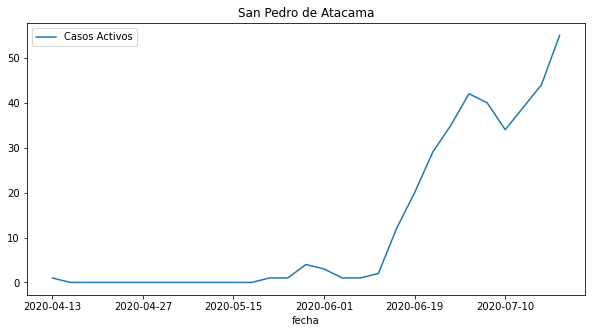

In [11]:
#Comuna = 'Las Condes'
Comuna = np.random.choice(comunas, 1, replace=False)[0]
sample = unpivoted[unpivoted['Comuna'] == Comuna]
sample.plot(x='fecha', y='Casos Activos', title=Comuna, figsize=(10,5))

Ya contamos con la data en una forma fácil de trabajar, ahora hay que hacer el match entre esta información y un archivo que contenga los **inputs** necesarios para construir las formas de las comunas en un mapa.

# Cargar información de archivo de formas

Para generar los polígonos que dan forma a las comunas en el mapa necesitamos recurrir a un conjunto de archivos de formas o **shape** que son también conocidos como mapas vectoriales. Para el caso de Chile esto archivos pueden encontrarse en la página de la Biblioteca del Congreso Nacional:

https://www.bcn.cl/siit/mapas_vectoriales

Como nuestro análisis se centra en las comunas, basta con descargar el archivo correspondiente a estas y, una vez descargado, descomprimirlo en la carpeta *Geo Info*.

Estos archivos pueden ser cargados usando geopandas:

**Nota 1: originalmente la estandarización de nombres de comunas era necesaria ya que el archivo de formas que utilice no tenía los códigos comunales así que era necesario hacer un **merge** con los nombres estandarizados. Con estos archivos más nuevos ya no es necesario pero decidí dejar la estandarización de todos modos por si resultáse útil en otros trabajos futuros.** 

**Nota 2: quedó comentado el comando para limitar el análisis a la provincia de Santiago.**

In [12]:
shape = gp.read_file('Geo info/comunas.shp')
#df_geo = shape[df_geo.NOM_PROV=='Santiago'].copy()
df_geo = shape.copy()
df_geo.shape

(346, 12)

In [13]:
df_geo.head(2)

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-7992818.789 -4056669.319, -7992731...."
1,29,125730.104795,15,8,6102,6,4.157446e+08,151911.576827,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((-7831651.813 -4022443.109, -7831596...."


---
Las 346 comunas de Chile.

Ahora vamos a revisar que cada código de comuna en el archivo del Ministerio coincida con una de las comunas. Para eso creamos listas únicas e iteramos.

In [14]:
geo_comunas_shp = list(df_geo['cod_comuna'].unique())
geo_comunas_min = list(df_chile['Codigo comuna'].unique())

In [15]:
excluidas = []
for c in geo_comunas_min:
    if c not in geo_comunas_shp:
        excluidas.append(c)

excluidas.append(0)
excluidas

[12202, 0]

In [16]:
df_chile.loc[df_chile['Codigo comuna'] == 12202]

,Region,Comuna,Codigo comuna,Poblacion,2020-04-13,2020-04-15,2020-04-17,2020-04-20,2020-04-24,2020-04-27,...,2020-06-19,2020-06-23,2020-06-28,2020-07-01,2020-07-05,2020-07-10,2020-07-13,2020-07-17,2020-07-20,Comuna_Clean
365,Magallanes y la Antartica,Antartica,12202,137.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Antartica


----
Se impuso que 0 también quede excluido ya que es lo que por defecto viene asociado a la información de los "desconocidos" que según la documentación del Producto 19 corresponden a registros de personas que no vamos a incluir en este análisis. La razón por la cuál debe ser excluido manualmente es porque corresponde también a un "zona sin demarcar" en el **df** de formas que existe debido a que la comuna de Antártica no está delimitada aún, es por esto que tampoco la encontramos cuando buscamos por su código comunal.

Ya con nuestros códigos comunales a excluir creamos el **df** final que utilizaremos:

In [17]:
unpivoted['filtro'] = unpivoted['Codigo comuna'].apply(lambda x: x not in excluidas)
final = unpivoted[unpivoted['filtro'] == True].copy()
final.drop(columns={'filtro'}, inplace=True)
final['Codigo comuna'] = final['Codigo comuna'].astype(int)

In [18]:
len(final.Comuna.unique())

345

Con esto nos aseguramos que las dimensiones correspondan.

# Preparar la información para folium

Lo primero que haremos en esta sección consta en algo más bien intuitivo que técnico. Como cada comuna tiene diferentes habitantes, una forma de estandarizar es mostrar la información cada mil habitantes:

In [19]:
final['CA cada 1000'] = (final['Casos Activos'] / final['Poblacion'])*1000
final.head()

,Comuna,Comuna_Clean,Codigo comuna,Poblacion,Region,fecha,Casos Activos,CA cada 1000
0,Arica,Arica,15101,247552.0,Arica y Parinacota,2020-04-13,88.0,0.355481
1,Camarones,Camarones,15102,1233.0,Arica y Parinacota,2020-04-13,0.0,0.000000
2,General Lagos,General_Lagos,15202,810.0,Arica y Parinacota,2020-04-13,0.0,0.000000
3,Putre,Putre,15201,2515.0,Arica y Parinacota,2020-04-13,0.0,0.000000
6,Alto Hospicio,Alto_Hospicio,1107,129999.0,Tarapaca,2020-04-13,8.0,0.061539


Ahora vamos a definir algunas funciones que nos van a ayudar a asignar colores a los diferentes valores según tramos. Aquí quiero dar las gracias al usuario de kaggle **python10am** por su repositorio en el cual me inspire fuertemente para estas funciones y la forma de estructurar la leyenda:

https://www.kaggle.com/python10pm/covid-19-in-spain-by-regions-daily-update


In [20]:
def get_hex_colors(value, cats):

    base = Color("green")
    final = Color("red")
    n = len(cats)
    colors = list(base.range_to(final,n+1))
    r = range(0, n-1)
    
    for i in r:
        if value in cats[i]:
            return colors[i].hex
        
    return colors[n].hex

In [21]:
def get_transparency(value, cats):
    n = len(cats)
    inicio = 0.4
    final = 0.9
    asdf = np.arange(inicio, final, (final - inicio)/n)
    r = range(0, n-1)
    
    for i in r:
        if value in cats[i]:
            return asdf[i]
    return asdf[n-1]

Ahora vamos a preparar las fechas para el plugin de **Folium** que necesita un formato especial. Lo primero será asegurarnos que nuestra columna de fechas efectivamente esté en un formato de fechas:

In [22]:
final.dtypes

Comuna            object
Comuna_Clean      object
Codigo comuna      int32
Poblacion        float64
Region            object
fecha             object
Casos Activos    float64
CA cada 1000     float64
dtype: object

---
Vamos a aplicar una pequeña transformación dado que nuestra columna de fecha es de tipo objeto:

In [23]:
final['fecha']=pd.to_datetime(final['fecha']).apply(lambda x: x + pd.DateOffset(days=0))
final.dtypes

Comuna                   object
Comuna_Clean             object
Codigo comuna             int32
Poblacion               float64
Region                   object
fecha            datetime64[ns]
Casos Activos           float64
CA cada 1000            float64
dtype: object

---
Luego vamos a crear el formato necesario convirtiendo la fecha a segundos:

In [24]:
final['Date_for_Folium']=((final['fecha'].astype(np.int64) // 10**9) + 60*60*24).astype('U10')
final.head()

,Comuna,Comuna_Clean,Codigo comuna,Poblacion,Region,fecha,Casos Activos,CA cada 1000,Date_for_Folium
0,Arica,Arica,15101,247552.0,Arica y Parinacota,2020-04-13,88.0,0.355481,1586822400
1,Camarones,Camarones,15102,1233.0,Arica y Parinacota,2020-04-13,0.0,0.000000,1586822400
2,General Lagos,General_Lagos,15202,810.0,Arica y Parinacota,2020-04-13,0.0,0.000000,1586822400
3,Putre,Putre,15201,2515.0,Arica y Parinacota,2020-04-13,0.0,0.000000,1586822400
6,Alto Hospicio,Alto_Hospicio,1107,129999.0,Tarapaca,2020-04-13,8.0,0.061539,1586822400


Ahora vamos a comenzar a asignar colores a los distintos valores. El valor de *n_tiles* es la cantidad de tramos que queremos usar:

In [25]:
data_to_color = "CA cada 1000"
n_tiles = 15
cats, bins =  pd.qcut(final[data_to_color].unique()[np.argsort(final[data_to_color].unique())], 
                      q = n_tiles, retbins = True)
cats = cats.unique()
#cats

---
Creamos columnas para asociar los colores y la opacidad que crrespondan.

In [26]:
final["COLORS"] = final[data_to_color].apply(get_hex_colors, args = [cats])
final["OPACITY"] = final[data_to_color].apply(get_transparency, args = [cats])

In [27]:
final.head()

,Comuna,Comuna_Clean,Codigo comuna,Poblacion,Region,fecha,Casos Activos,CA cada 1000,Date_for_Folium,COLORS,OPACITY
0,Arica,Arica,15101,247552.0,Arica y Parinacota,2020-04-13,88.0,0.355481,1586822400,#56a200,0.533333
1,Camarones,Camarones,15102,1233.0,Arica y Parinacota,2020-04-13,0.0,0.000000,1586822400,#008000,0.400000
2,General Lagos,General_Lagos,15202,810.0,Arica y Parinacota,2020-04-13,0.0,0.000000,1586822400,#008000,0.400000
3,Putre,Putre,15201,2515.0,Arica y Parinacota,2020-04-13,0.0,0.000000,1586822400,#008000,0.400000
6,Alto Hospicio,Alto_Hospicio,1107,129999.0,Tarapaca,2020-04-13,8.0,0.061539,1586822400,#008000,0.400000


---
Ahora creamos listas en las que vamos a iterar para crear un tipo de diccionario que requiere **Folium**:

In [28]:
cod_comunas = list(final["Codigo comuna"].unique())
fechas = list(final["Date_for_Folium"].unique())

In [29]:
styledict = {}

for com in cod_comunas:
    styledict[str(com)] = {date: {'color': final[(final["Codigo comuna"] == com) & 
                                                 (final["Date_for_Folium"] == date)]["COLORS"].values[0],
                                   'opacity': final[(final["Codigo comuna"] == com) &
                                                    (final["Date_for_Folium"] == date)]["OPACITY"].values[0]} for date in fechas}

Ya estamos casi listos, es más podríamos crear el mapa con lo que tenemos, pero sería difícil de interpretar ya que no tendría leyenda.

# Crear leyenda para el mapa

Vamos a replicar lo que al función **get_hex_colors** hace para tener un glosario de colores:

In [38]:
color_base = Color("green")
color_final = Color("red")
n = len(cats)
the_colors = list(color_base.range_to(color_final,n+1))
rango = range(0, n-1)

Lo que viene a continuación requiere de entender HTML pero básicamente vamos a crear una leyenda sencilla iterando sobre la lista *the_colors*. Quizás si el lector tiene experiencia en **webscrapping** esto le sea más familiar pero dejo de todos modos un módulo para insertar el nombre para la leyenda del mapa:

In [39]:
tu_nombre =  "Camilo Fuentes M."
html_li_nombre =  "<li>por " + tu_nombre + "</li>"

In [47]:
parte1 = """     
    <li><span style='background:
    """
parte2 = """     
    ;opacity:0.6;'></span>
    """
parte3 ="""
    </li>
    
    """

asdf2 = ""

for r in rango:
    descripcion = str(cats[r])
    asdf2 = asdf2 + parte1 + the_colors[r].hex + parte2 + descripcion + parte3

descripcion = '>' +str(cats[n-1].right)
asdf2 = asdf2 + parte1 + the_colors[n].hex + parte2 + descripcion + parte3

In [48]:
a = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.9);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Casos Actvos cada 1000 personas</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
"""

b = """
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

template = a + asdf2 + html_li_nombre + b

# Crear el mapa

Vamos a indicar el código comunal como índice y lo vamos a entregar como argumento junto a todo lo que ya hemos preparado y vamos a guardar el resultado en la carpeta *docs*:

In [49]:
this = df_geo.set_index('cod_comuna')

In [50]:
import branca.colormap as cm
from branca.element import Template, MacroElement

#Mapa que muestre gran parte del país.
m = folium.Map(location=(-40, -71), tiles='Stamen Toner', zoom_start=4)

#Agregar el plugin del mapa coroplético con barra deslizante de tiempo
g = TimeSliderChoropleth(
    this, # get's the coordinates for each id 
    styledict = styledict # styledict contains for each id the timestamp and the color to plot.
)
m.add_child(g)

#Agregar la leyenda
macro = MacroElement()
macro._template = Template(template)
m.get_root().add_child(macro)

#Elegir la dirección
html_location = './docs/Casos Activos COVID19 cada 1000 habitantes por Comunda de Chile.html' 

#Guardar el mapa.
m.save(html_location)

---
*(Si aparece un mensaje de advertencia sobre **pyproj** es muy probable que la versión de **geopandas** del entorno no esté actualizada.)*

Ahora veamos como queda finalmente le mapa!

In [51]:
IFrame(src=html_location, width=1000, height=600)

De esta manera podemos generar una herramienta de visualización comida e interactiva. No solo podemos enfocarnos en áreas usando el **zoom** si no que también podemos ver la evolución temporal con la barra. La limitante aquí es el tamaño de los archivos generados, pero si esto resulta problemático siempre existe la opción de utilizar la vía acotada a regiones y generar visualizaciones de sectores más específicos.

Uno de los análisis que rápidamente podemos hacer es notar la presencia inicial de algo que podría parecer un **outlier** en la región de Tarapacá por su elevado valor en las primeras fechas:

<div style="margin:1px auto, position: absolute">
<img src="image/200823 Tarapaca.gif" width="800" height="300" align="center"/>
</div>

Podemos hacer un enfoque en dicha zona de esta manera:

In [ ]:
final[(final['fecha'] == '2020-04-13') & (final['Region'] == 'Tarapaca')]

---
Con esto notamos que corresponde a la comuna de Pica, usando el gráfico que construimos anteriormente podemos analizar más en detalle cómo ha sido la evolución en la Comuna:

In [ ]:
Comuna = 'Pica'
sample = final[final['Comuna'] == Comuna]
sample.plot(x='fecha', y='CA cada 1000', title=Comuna, figsize=(10,5))

---
O concentrarnos en la evolución de la región y así observar comparativamente a la comuna *vs* su entorno:

In [ ]:
Region = 'Tarapaca'
sample2 = final[final['Region'] == Region]
pivoted_region = sample2.pivot(index='fecha' , columns = 'Comuna', values='CA cada 1000').reset_index()
pivoted_region.plot(x='fecha', figsize=(12,8), title='Región de' + Region + ' - CA cada 1000 habitantes')

---
Otro enfoque posible sería escoger una vista orientada a una provincia en específico. Si bien el archivo del Ministerio no cuenta con la clasificación comunal por provincias podemos rescatar este dato del **df** de formas que usamos para marcar las comunas en el mapa:

In [ ]:
provincias_dic = df_geo[['cod_comuna', 'Provincia']]
provincias_dic.head()

In [ ]:
final_prov = final.merge(provincias_dic, left_on='Codigo comuna', right_on='cod_comuna')
final_prov.head()

In [ ]:
Provincia = 'Concepción'
sample3 = final_prov[final_prov['Provincia'] == Provincia]
pivoted_provincia = sample3.pivot(index='fecha' , columns = 'Comuna', values='CA cada 1000').reset_index()
pivoted_provincia.plot(x='fecha', figsize=(12,8), title='Provincia de ' + Provincia + ' - CA cada 1000 habitantes')

In [ ]:
Provincia = 'Santiago'
sample3 = final_prov[final_prov['Provincia'] == Provincia]
pivoted_provincia = sample3.pivot(index='fecha' , columns = 'Comuna', values='CA cada 1000').reset_index()
pivoted_provincia.plot(x='fecha', figsize=(16,12), title='Provincia de ' + Provincia + ' - CA cada 1000 habitantes')

Estas son solo unas primeras muestras de los múltiples **insights** que se pueden obtener de una visualización interactiva.

Existen más enfoques que se pueden aplicar con los mismos productos que ofrece el Ministerio de Ciencia ya que siguen una lógica de construcción bastante similar. Es con toda la intención de proponer herramientas diferentes y didácticas que todo lo anterior ha sido presentado y explicado.

**Espero haya sido un recorrido ameno que y gracias por leer,**

**Camilo Fuentes M.**